## Importing modules

In [19]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import sparse
from itertools import combinations

# Learning from the expert: processing
This chapter shows the tips and tricks used by the winner. Some are text processing, some are statistical methods, and some are computational efficiency. Knowing which tools to combine allows us to build extremely effective models. 

The first NLP trick used was to tokenize on punctuation. By tokenizing on punctuation to avoid hyphens, underscores, etc., the winner realised there are better ways to tokenize than on just spaces. 

Also, the winner used unigrams and bi-grams in the model to capture important information involving multiple tokens - e.g., ‘middle school’

Scikit learn implements many of these methods for us and these are well tested by a large community. To change tokenization and add bigrams, we change the call to countvectorizer and pass the regular expression (defined back in Chapter 2) to only accept alphanumeric characters in our tokens. We also tell it to accept ngrams 1 and 2 – to include unigrams and bigrams in the vectorization. 

    vec = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC, ngram_range=(1, 2))

Having updated CountVectorizer with these changes, we can then add it to the pipeline and fit this in the same way we have been doing throughout the course.  

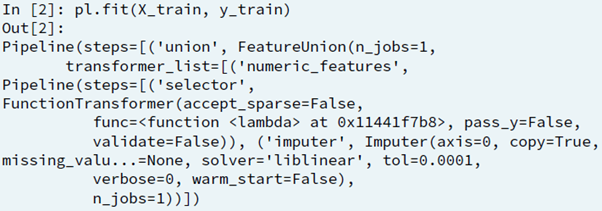

Getting predictions is the same. We use the predict_proba function to get class probabilities. Because we’ve built the preprocessing into the pipeline, we don’t need to do any additional processing on our holdout data when we load it: the pipeline represents the entire prediction process, from raw data to class probabilities. 

## How many tokens?

Recall from previous chapters that how you tokenize text affects the n-gram statistics used in your model.

Going forward, you'll use alpha-numeric sequences, and only alpha-numeric sequences, as tokens. Alpha-numeric tokens contain only letters a-z and numbers 0-9 (no other characters). In other words, you'll tokenize on punctuation to generate n-gram statistics.

In this exercise, you'll make sure you remember how to tokenize on punctuation.

Assuming we tokenize on punctuation, accepting only alpha-numeric sequences as tokens, how many tokens are in the following string from the main dataset?

    'PLANNING,RES,DEV,& EVAL      '

If you want, we've loaded this string into the workspace as <span style="color:blue">SAMPLE_STRING</span>, but you may not need it to answer the question.

* 4, because RES and DEV are not tokens
* __4, because , and & are not tokens__
* 7, because there are 4 different words, some commas, an & symbol, and whitespace
* 7, because there are 7 whitespaces

In [20]:
SAMPLE_STRING = 'PLANNING,RES,DEV,& EVAL      '

## Deciding what's a word

Before you build up to the winning pipeline, it will be useful to look a little deeper into how the text features will be processed.

In this exercise, you will use <span style="color:blue">CountVectorizer</span> on the training data <span style="color:blue">X_train</span> (preloaded into the workspace) to see the effect of tokenization on punctuation.

Remember, since <span style="color:blue">CountVectorizer</span> expects a vector, you'll need to use the preloaded function, <span style="color:blue">combine_text_columns</span> before fitting to the training data.

In [21]:
# load the dataframe and define the columns of interest
import pandas as pd
X_train = pd.read_csv('X_train.csv', index_col=0)

NUMERIC_COLUMNS = ['FTE', 'Total']
LABELS = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']

In [22]:
# Define combine_text_columns()
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace nans with blanks
    text_data.fillna('', inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [23]:
# Import the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Create the text vector
text_vector = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate the CountVectorizer: text_features
text_features = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Fit text_features to the text vector
text_features.fit(text_vector)

# Print the first 10 tokens
print(text_features.get_feature_names()[:10])

['1st', '2nd', '3rd', '5th', '70', '8', 'a', 'aaps', 'ab', 'academic']


## N-gram range in scikit-learn

In this exercise you'll insert a <span style="color:blue">CountVectorizer</span> instance into your pipeline for the main dataset, and compute multiple n-gram features to be used in the model.

In order to look for ngram relationships at multiple scales, you will use the <span style="color:blue">ngram_range</span> parameter as Peter discussed in the video.

__Special functions__: You'll notice a couple of new steps provided in the pipeline in this and many of the remaining exercises. Specifically, the <span style="color:blue">dim_red</span> step following the <span style="color:blue">vectorizer step</span>, and the <span style="color:blue">scale step preceeding the <span style="color:blue">clf</span> (classification) step.

These have been added in order to account for the fact that you're using a reduced-size sample of the full dataset in this course. To make sure the models perform as the expert competition winner intended, we have to apply a [dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) technique, which is what the <span style="color:blue">dim_red</span> step does, and we have to [scale the features](https://en.wikipedia.org/wiki/Feature_scaling) to lie between -1 and 1, which is what the <span style="color:blue">scale</span> step does.

The <span style="color:blue">dim_red</span> step uses a scikit-learn function called <span style="color:blue">SelectKBest()</span>, applying something called the [chi-squared test](https://en.wikipedia.org/wiki/Chi-squared_test) to select the K "best" features. The <span style="color:blue">scale</span> step uses a scikit-learn function called <span style="color:blue">MaxAbsScaler()</span> in order to squash the relevant features into the interval -1 to 1.

You won't need to do anything extra with these functions here, just complete the vectorizing pipeline steps below. However, notice how easy it was to add more processing steps to our pipeline!

* [.SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)
* [MaxAbsScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
* [sklearn.preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
* [sklearn.feature_selection](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)

In [24]:
# Import pipeline
from sklearn.pipeline import Pipeline

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Import other preprocessing modules
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import chi2, SelectKBest

# Select 300 best features
chi_k = 300

# Import functional utilities
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.pipeline import FeatureUnion

# Perform preprocessing
get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Learning from the expert: a stats trick

The statistical tool the winner used is called interaction terms. For example:

* English teacher for 2nd grade
* 2nd grade - budget for English teacher

Are equivalent, but simple n-grams would see them as being different. Using interaction terms allows us to check when two terms appear together. As an example, consider a simple linear model. Betas are coefficients showing how important that independent variable is. The interaction term is only a 1 if both occur. B3 shows how important the occurrence of the two terms together is. 

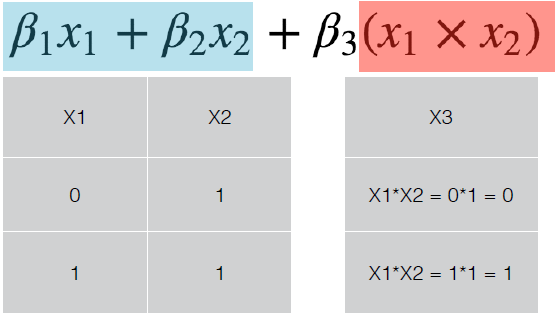


Interaction terms are part of the sklearn preprocessing module and is part of the PolynomialFeatures functionality. We can add the degree of interaction, though doing so becomes increasingly computationally expensive. The interaction_only=True tells the function to not multiply a column by itself. The fit_transform method gives the output like the last slide with the new column added

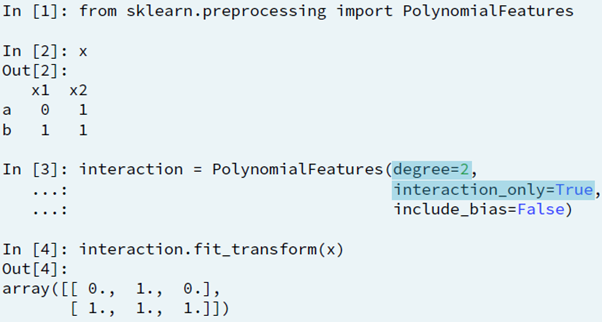

include_bias creates an offset. For example, plotting age vs weight for babies gives a regression line that has a value of 7.5lbs when the baby is born. The bias term would allow the model to predict a non-zero y value even when the x value is zero. 

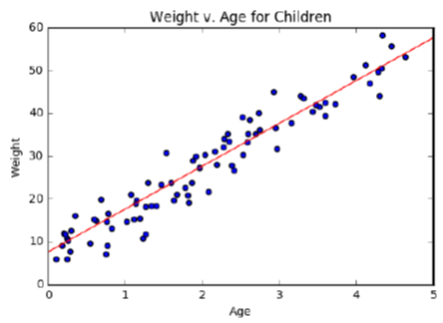

Adding interaction terms makes the x-array grow exponentially. CountVectorizer therefore returns an object called a sparse matrix. PolynomialFeatures does not support sparse matrices, so a replacement is used in the following problems, SparseInteractions. You only need to pass it the ‘degree’ parameter for it to work in the same way. 

## Which models of the data include interaction terms?

Recall from the video that interaction terms involve products of features.

Suppose we have two features x and y, and we use models that process the features as follows:

    βx + βy + ββ
    βxy + βx + βy
    βx + βy + βx^2 + βy^2

where β is a coefficient in your model (not a feature).

Which expression(s) include interaction terms?

* The first expression
* __The second expression__
* The third expression
* The first and third expressions.

## Implement interaction modeling in scikit-learn

It's time to add interaction features to your model. The <span style="color:blue">PolynomialFeatures</span> object in scikit-learn does just that, but here you're going to a custom interaction object, <span style="color:blue">SparseInteractions</span>. Interaction terms are a statistical tool that lets your model express what happens if two features appear together in the same row.

<span style="color:blue">SparseInteractions</span> does the same thing as <span style="color:blue">PolynomialFeatures</span>, but it uses sparse matrices to do so. You can get the code for <span style="color:blue">SparseInteractions</span> at [this GitHub Gist](https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/features/SparseInteractions.py).

<span style="color:blue">PolynomialFeatures</span> and <span style="color:blue">SparseInteractions</span> both take the argument <span style="color:blue">degree</span>, which tells them what polynomia degree of interactions to compute.

You're going to consider interaction terms of <span style="color:blue">degree=2</span> in your pipeline. You will insert these steps after the preprocessing steps you've built out so far, but before the classifier steps.

Pipelines with interaction terms take a while to train (since you're making n features into n-squared features!), so as long as you set it up right, we'll do the heavy lifting and tell you what your score is!

The SparseInteractions code is found [here](https://gist.github.com/pjbull/063a9b4e4f9cfcc4d03cba18fee63de7)

* [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import sparse
from itertools import combinations


class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)
            
        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])
            
        spi = self._create_sparse_interactions(X)
        return spi
    
    
    def get_feature_names(self):
        return self.feature_names
    
    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()
        
        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)
                
                # get column multiplications value
                out = X[:, col_ixs[0]]    
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

In [26]:
# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),  
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Learning from the expert: a computational trick and the winning model

We need to balance adding new features with the computational costs of additional columns. Adding 3 or 4-grams increases the array and requires more computational power. Hashing is a way to limit the size of the matrix without sacrificing too much model accuracy. Hashing takes an input and gives an output, that may be an integer

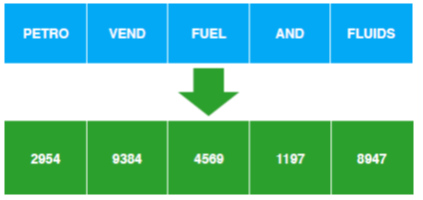

We might limit the output of the hashing function – e.g. to 250 outputs. The hashing vectorizer then maps every token to one of those 250 columns. Some columns will have multiple tokens that map to them. Even when this is so, there is very little effect on model accuracy in real world problems. 

We have been working with a subset of the full data, the size of which is actually part of the challenge. We want to do as much as possible to limit the size of the features array. Doing so is called dimensionality reduction. The hashing trick is very useful in large datasets with lots of text data

Implememting the hashing trick is very simple in scikit learn. Instead of implementing the countvectorizer, and its bag of words representation, we change to the hashing vectorizer. We can use the same token pattern and n-gram range as before. The parameters norm=True and non_negative=True let us drop in the hashing vectorizer as a replacement for countvectorizer (See documentation). We now use this in the pipeline instead of the countvectorizer.

In summary, the winning model used three winning tricks:

* The NLP used bigrams and tokenized on punctuation
* The statistical trick was to add interaction terms to the model 
* The computational trick was to use a hashing vectorizer

But what class of model did the winner use? In fact it was just a simple logistic regression model. The competition was not won by a cutting edge algorithm, but by thinking carefully about how to create features for the model and using a couple of easily implemented tricks. You should favour simplicity over complexity as a rule. 


## Why is hashing a useful trick?

In the video, Peter explained that a [hash](https://en.wikipedia.org/wiki/Feature_hashing#Feature_vectorization_using_the_hashing_trick) function takes an input, in your case a token, and outputs a hash value. For example, the input may be a string and the hash value may be an integer.

We've loaded a familiar python datatype, a dictionary called <span style="color:blue">hash_dict</span>, that makes this mapping concept a bit more explicit. In fact, [python dictionaries ARE hash tables!](https://stackoverflow.com/questions/114830/is-a-python-dictionary-an-example-of-a-hash-table)

Print <span style="color:blue">hash_dict</span> in the IPython Shell to get a sense of how strings can be mapped to integers.

By explicitly stating how many possible outputs the hashing function may have, we limit the size of the objects that need to be processed. With these limits known, computation can be made more efficient and we can get results faster, even on large datasets.

Using the above information, answer the following:

Why is hashing a useful trick?

* Hashing isn't useful unless you're working with numbers.
* Some problems are memory-bound and not easily parallelizable, but hashing parallelizes them.
* __Some problems are memory-bound and not easily parallelizable, and hashing enforces a fixed length computation instead of using a mutable datatype (like a dictionary).__
* Hashing enforces a mutable length computation instead of using a fixed length datatype, like a dictionary.


## Implementing the hashing trick in scikit-learn

In this exercise you will check out the scikit-learn implementation of <span style="color:blue">HashingVectorizer</span> before adding it to your pipeline later.

As you saw in the video, <span style="color:blue">HashingVectorizer</span> acts just like <span style="color:blue">CountVectorizer</span> in that it can accept <span style="color:blue">token_pattern</span> and <span style="color:blue">ngram_range parameters</span>. The important difference is that it creates hash values from the text, so that we get all the computational advantages of hashing!

* [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html)
* [sklearn.feature_extraction](http://scikit-learn.org/stable/modules/feature_extraction.html)
* [sklearn.feature_extraction.text](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text)
* [HashingVectorizer.fit_transform](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html#sklearn.feature_extraction.text.HashingVectorizer.fit_transform)

In [27]:
# Import HashingVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Get text data: text_data
text_data = combine_text_columns(X_train)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)' 

# Instantiate the HashingVectorizer: hashing_vec
hashing_vec = HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Fit and transform the Hashing Vectorizer
hashed_text = hashing_vec.fit_transform(text_data)

# Create DataFrame and print the head
hashed_df = pd.DataFrame(hashed_text.data)
print(hashed_df.head())

          0
0 -0.154303
1  0.154303
2 -0.154303
3  0.771517
4  0.154303


## Build the winning model

You have arrived! This is where all of your hard work pays off. It's time to build the model that won DrivenData's competition.

You've constructed a robust, powerful pipeline capable of processing training and testing data. Now that you understand the data and know all of the tools you need, you can essentially solve the whole problem in a relatively small number of lines of code. Wow!

All you need to do is add the <span style="color:blue">HashingVectorizer</span> step to the pipeline to replace the <span style="color:blue">CountVectorizer</span> step.

The parameters <span style="color:blue">non_negative=True</span>, <span style="color:blue">norm=None</span>, and <span style="color:blue">binary=False</span> make the <span style="color:blue">HashingVectorizer</span> perform similarly to the default settings on the <span style="color:blue">CountVectorizer</span> so you can just replace one with the other.

In [28]:
# Import the hashing vectorizer
from sklearn.feature_extraction.text import HashingVectorizer

# Instantiate the winning model pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', Imputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                     non_negative=True, norm=None, binary=False,
                                                     ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

## Appendix: Methods

* [.SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)
* [MaxAbsScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html)
* [sklearn.preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
* [sklearn.feature_selection](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)
* [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
* [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html)
* [sklearn.feature_extraction](http://scikit-learn.org/stable/modules/feature_extraction.html)
* [sklearn.feature_extraction.text](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text)
* [HashingVectorizer.fit_transform](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html#sklearn.feature_extraction.text.HashingVectorizer.fit_transform)